In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet

In [29]:
df = pd.read_parquet("meow_df.parquet", engine = 'fastparquet')

df.columns

df['time_diff'] = df.seconds_in_bucket - df.seconds_in_bucket_before

df = df.query("""time_id == time_id_before and stock_id == stock_id_before""")

df = df.drop(columns = ['time_id_before', 'seconds_in_bucket_before', 'stock_id_before', 'level_0'])

df['trade'] = (df.price >= df.ask_price1_before).astype(int) - (df.price <= df.bid_price1_before).astype(int)

<Axes: ylabel='Frequency'>

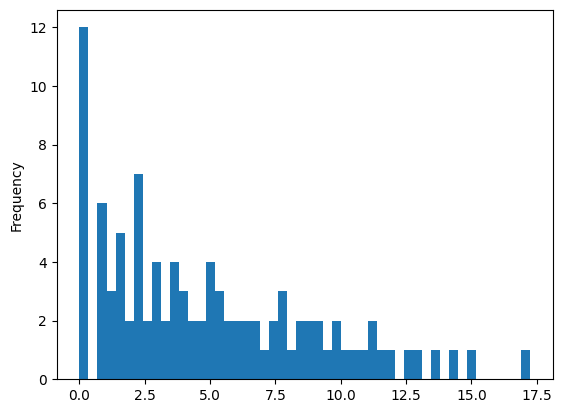

In [43]:
np.log(df.time_diff.value_counts()).plot.hist(bins = 50)

In [ ]:
#meow moew